# Predicting Bankruptcy

#### Done by: Jordan Seow Hua Jun

## Contents

### [Section 1](#1)
- 1.1 Calculate Altman Z-Score
- 1.2 Classify Bankruptcy

### [Section 2](#2)
- 2.1 Logistic Regression: Cross-Validation
- 2.2 CART Decision Tree: Cross-Validation
- 2.3 XGBoost: Cross-Validation
- 2.4 Evaluation

### [Section 3](#3)
- 3.1 SMOTE (Oversampling)
- 3.2 SMOTE (Oversampling) + Edited Nearest Neighbours (Undersampling)
- 3.3 Over-Weighting Minority Class
- 3.4 Evaluation

### [Section 4](#4)
- 4.1 Data Preprocessing
- 4.2 Narrowing Hyperparameter Search Space with RandomizedSearch
- 4.3 Use Hyperopt to Find Best Hyperparameters
- 4.4 Evaluation
- 4.5 Prediction on Test Dataset

### [Section 5](#5)
- 5.1 Best Model's Top 10 Features
- 5.2 Evaluation of Features


### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV, cross_val_score, train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.combine import SMOTEENN

from copy import deepcopy
from sklearn.preprocessing import LabelEncoder

from time import time
from tqdm import tqdm
import os, pickle

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

pd.options.display.max_colwidth=2000
pd.options.display.max_columns=None

### Random State

In [2]:
SEED = 1

### Read Train Dataset

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.head()

,gvkey,datadate,conm,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,ni,niadj,oiadp,pi,re,revt,sale,wcap,xido,xopr,mkvalt,sic,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5
0,1240,2002-01-31,ALBERTSON'S INC,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,3582.000,10052.000,501.000,501.000,1787.000,873.000,5414.000,37931.000,37931.000,1027.000,0.000,35118.000,11701.2500,5411.0,0,0.064320,0.339074,0.111918,1.164072,2.375587
1,1655,2002-01-31,ANGELICA CORP,290.865,246.466,8.608,0.0,12.856,103.597,1.629,133.169,149.361,-22.709,-22.709,12.856,1.790,142.188,350.063,350.063,46.960,-24.338,326.107,101.5744,7200.0,0,0.161449,0.488845,0.044199,0.680060,1.203524
2,1864,2002-01-31,REX AMERICAN RESOURCES CORP,307.329,325.912,8.163,0.0,22.236,138.591,22.554,66.035,159.356,22.309,22.309,22.236,30.007,134.708,464.503,464.503,92.256,-0.245,438.069,240.4004,2860.0,0,0.300186,0.438319,0.072352,1.508575,1.511419
3,1878,2002-01-31,AUTODESK INC,902.444,124.903,55.644,0.0,131.804,822.588,90.313,370.651,373.130,90.313,90.313,131.804,125.482,71.892,947.491,947.491,193.219,0.000,768.484,2281.4040,7370.0,0,0.214106,0.079664,0.146052,6.114234,1.049917
4,2436,2002-01-31,CALERES INC,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,301.453,444.242,-3.962,-3.962,54.842,-5.675,145.053,1755.848,1755.848,225.457,-4.911,1674.299,278.6950,3140.0,0,0.321669,0.206953,0.078245,0.627350,2.505141


### Data Preprocessing

In [5]:
pd.DataFrame(train.dtypes).rename(columns={0:'Data Type'})

,Data Type
gvkey,int64
datadate,object
conm,object
at,float64
cogs,float64
csho,float64
dvp,float64
ebit,float64
gp,float64
ib,float64


In [6]:
train['sic'] = train['sic'].astype('int')
train = train.astype({'gvkey': 'category',
                      'datadate': 'datetime64[ns]',
                      'sic': 'category'})

In [7]:
pd.DataFrame(train.dtypes).rename(columns={0:'Data Type'})

,Data Type
gvkey,category
datadate,datetime64[ns]
conm,object
at,float64
cogs,float64
csho,float64
dvp,float64
ebit,float64
gp,float64
ib,float64


## <a id='1'>Section 1</a>

In [8]:
X = train.iloc[:,-5:]
y = train.iloc[:, -6]
df = pd.concat([X, y], axis=1)

In [9]:
df.head()

,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,bankrupt
0,0.064320,0.339074,0.111918,1.164072,2.375587,0
1,0.161449,0.488845,0.044199,0.680060,1.203524,0
2,0.300186,0.438319,0.072352,1.508575,1.511419,0
3,0.214106,0.079664,0.146052,6.114234,1.049917,0
4,0.321669,0.206953,0.078245,0.627350,2.505141,0


### 1.1 Calculate Altman Z-Score

#### Altman Z-Score = 1.2 * X1 + 1.4 * X2 + 3.3 * X3 + 0.6 * X4 + 1.0 * X5

In [10]:
def calculate_altman_z_score(x1, x2, x3, x4, x5):
    z_score = 1.2*x1 + 1.4*x2 + 3.3*x3 + 0.6*x4 + 1.0*x5
    return z_score

In [11]:
df['Altman_Z_Score'] = df.apply(lambda x: calculate_altman_z_score(x['Altman_X1'], 
                                                                   x['Altman_X2'], 
                                                                   x['Altman_X3'], 
                                                                   x['Altman_X4'], 
                                                                   x['Altman_X5']), 
                                axis=1)

In [12]:
df.head()

,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,bankrupt,Altman_Z_Score
0,0.064320,0.339074,0.111918,1.164072,2.375587,0,3.995249
1,0.161449,0.488845,0.044199,0.680060,1.203524,0,2.635540
2,0.300186,0.438319,0.072352,1.508575,1.511419,0,3.629197
3,0.214106,0.079664,0.146052,6.114234,1.049917,0,5.568886
4,0.321669,0.206953,0.078245,0.627350,2.505141,0,3.815497


### 1.2 Classify Bankruptcy

#### Classify with Altman Z-Score Cut-Off Value at 2.675

In [13]:
def classify_bankrupt(altman_z_score):
    return 1 if altman_z_score < 2.675 else 0

In [14]:
df['bankrupt_pred'] = df['Altman_Z_Score'].apply(lambda x: classify_bankrupt(x))

In [15]:
df.head()

,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,bankrupt,Altman_Z_Score,bankrupt_pred
0,0.064320,0.339074,0.111918,1.164072,2.375587,0,3.995249,0
1,0.161449,0.488845,0.044199,0.680060,1.203524,0,2.635540,1
2,0.300186,0.438319,0.072352,1.508575,1.511419,0,3.629197,0
3,0.214106,0.079664,0.146052,6.114234,1.049917,0,5.568886,0
4,0.321669,0.206953,0.078245,0.627350,2.505141,0,3.815497,0


#### Classification Report

In [16]:
print(classification_report(df['bankrupt'], df['bankrupt_pred']))

              precision    recall  f1-score   support

           0       1.00      0.58      0.73     26638
           1       0.01      0.91      0.03       181

    accuracy                           0.58     26819
   macro avg       0.51      0.74      0.38     26819
weighted avg       0.99      0.58      0.73     26819



#### F1-Score

In [17]:
f1 = f1_score(df['bankrupt'], df['bankrupt_pred'])
print(f'F1-Score: {f1}')

F1-Score: 0.028398268398268398


#### Confusion Matrix

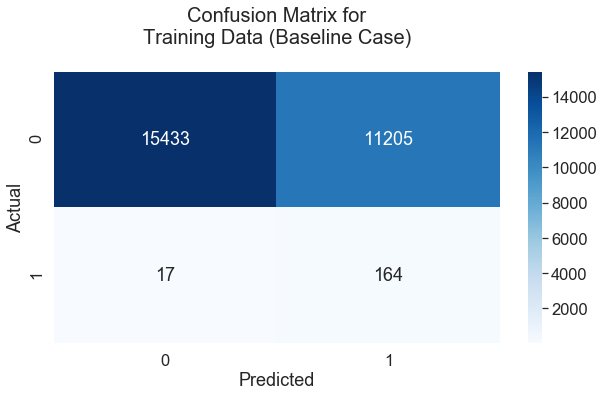

In [18]:
cm_data = confusion_matrix(df['bankrupt'], df['bankrupt_pred'])
df_cm = pd.DataFrame(cm_data, columns=np.unique(df['bankrupt']), index=np.unique(df['bankrupt']))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':18}, fmt='g')
plt.title("Confusion Matrix for\nTraining Data (Baseline Case)\n", size=20)
plt.show()

## <a id='2'>Section 2</a>

#### With *Altman_X1*, *Altman_X2*, *Altman_X3*, *Altman_X4*, *Altman_X5* as Input Features and *bankrupt* as Label

In [19]:
x_var = ['Altman_X1', 'Altman_X2', 'Altman_X3', 'Altman_X4', 'Altman_X5']
y_var = 'bankrupt'

#### 5-Fold Stratified Cross-Validation

In [20]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

### 2.1 Logistic Regression: Cross-Validation

In [21]:
all_y_preds = []
all_y_proba = []
all_y_true = []

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    log_clf = LogisticRegression(random_state=SEED)
    log_clf.fit(X_train, np.ravel(y_train))
    y_preds = log_clf.predict(X_test)
    y_proba = log_clf.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

#### Classification Report

In [22]:
print(classification_report(all_y_true, all_y_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26638
           1       0.50      0.04      0.08       181

    accuracy                           0.99     26819
   macro avg       0.75      0.52      0.54     26819
weighted avg       0.99      0.99      0.99     26819



#### F1-Score

In [23]:
f1_log = f1_score(all_y_true, all_y_preds)
print(f"F1-Score: {f1_log}") 

F1-Score: 0.08121827411167512


#### Confusion Matrix

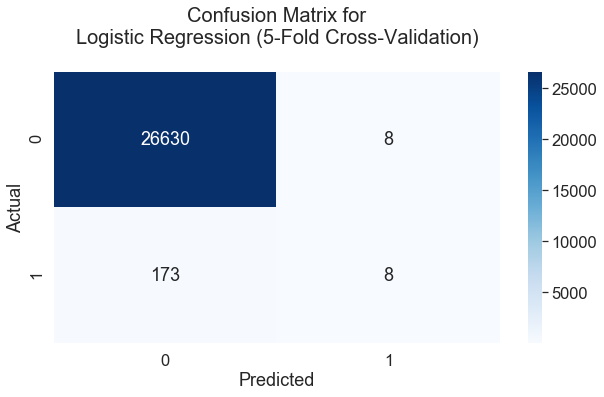

In [24]:
cm_data = confusion_matrix(all_y_true, all_y_preds)
df_cm = pd.DataFrame(cm_data, columns=np.unique(all_y_true), index=np.unique(all_y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':18}, fmt='g')
plt.title("Confusion Matrix for\nLogistic Regression (5-Fold Cross-Validation)\n", size=20)
plt.show()

### 2.2 CART Decision Tree: Cross-Validation

In [25]:
all_y_preds = []
all_y_proba = []
all_y_true = []

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    dt_clf = DecisionTreeClassifier(random_state=SEED)
    dt_clf.fit(X_train, y_train)
    y_preds = dt_clf.predict(X_test)
    y_proba = dt_clf.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

#### Classification Report

In [26]:
print(classification_report(all_y_true, all_y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26638
           1       0.12      0.14      0.13       181

    accuracy                           0.99     26819
   macro avg       0.56      0.57      0.56     26819
weighted avg       0.99      0.99      0.99     26819



#### F1-Score

In [27]:
f1_dt = f1_score(all_y_true, all_y_preds)
print(f"F1-Score: {f1_dt}") 

F1-Score: 0.13089005235602091


#### Confusion Matrix

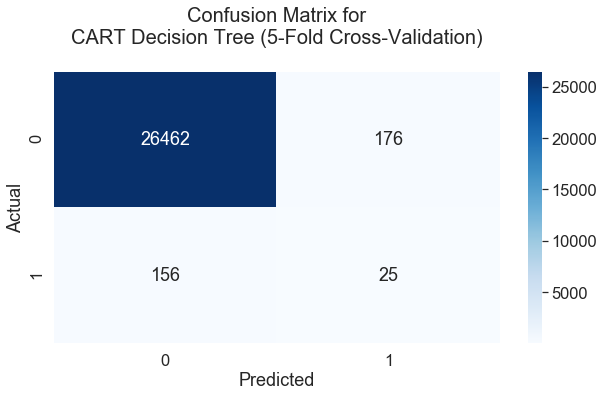

In [28]:
cm_data = confusion_matrix(all_y_true, all_y_preds)
df_cm = pd.DataFrame(cm_data, columns=np.unique(all_y_true), index=np.unique(all_y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':18}, fmt='g')
plt.title("Confusion Matrix for\nCART Decision Tree (5-Fold Cross-Validation)\n", size=20)
plt.show()

### 2.3 XGBoost: Cross-Validation

In [29]:
all_y_preds = []
all_y_proba = []
all_y_true = []

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    xg_clf = XGBClassifier(random_state=SEED)
    xg_clf.fit(X_train, y_train)
    y_preds = xg_clf.predict(X_test)
    y_proba = xg_clf.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

#### Classification Report

In [30]:
print(classification_report(all_y_true, all_y_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     26638
           1       0.22      0.04      0.07       181

    accuracy                           0.99     26819
   macro avg       0.61      0.52      0.53     26819
weighted avg       0.99      0.99      0.99     26819



#### F1-Score

In [31]:
f1_xg = f1_score(all_y_true, all_y_preds)
print(f"F1-Score: {f1_xg}") 

F1-Score: 0.07373271889400922


#### Confusion Matrix

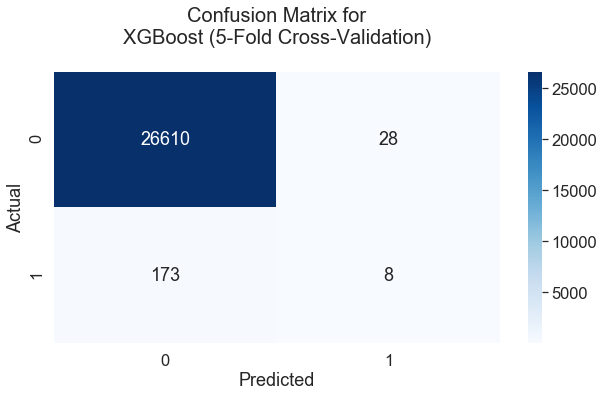

In [32]:
cm_data = confusion_matrix(all_y_true, all_y_preds)
df_cm = pd.DataFrame(cm_data, columns=np.unique(all_y_true), index=np.unique(all_y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':18}, fmt='g')
plt.title("Confusion Matrix for\nXGBoost (5-Fold Cross-Validation)\n", size=20)
plt.show()

### 2.4 Evaluation

In [33]:
technique_performance = pd.DataFrame({"Technique": ["Logistic Regression", 
                                                    "CART Decision Tree",
                                                    "XGBoost"],
                                      "F1-Score": [f1_log, f1_dt, f1_xg]})

technique_performance.sort_values(by="F1-Score", ascending=False)

,Technique,F1-Score
1,CART Decision Tree,0.130890
0,Logistic Regression,0.081218
2,XGBoost,0.073733


## <a id='3'>Section 3</a>

In [34]:
bankrupt_count = pd.DataFrame(train['bankrupt'].value_counts()).rename(columns={'bankrupt':'Count'})
bankrupt_count['Percentage of Total (%)'] = (bankrupt_count['Count']/len(train))*100
bankrupt_count

,Count,Percentage of Total (%)
0,26638,99.325105
1,181,0.674895


There is imbalanced class that needs to be handled.

### 3.1 SMOTE (Oversampling)

In each split, oversample to target a 1:2 minority:majority ratio (`sampling_strategy` = 0.5)

In [35]:
all_y_preds = []
all_y_proba = []
all_y_true = []
split = 1
for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    sm = SMOTE(random_state=SEED, sampling_strategy=0.5)
    X_smote, y_smote = sm.fit_resample(X_train, y_train)
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    bankrupt_count_smote = pd.DataFrame(y_smote.value_counts()).rename(columns={'bankrupt':'Count'})
    bankrupt_count_smote['Percentage of Total (%)'] = (bankrupt_count_smote['Count']/len(y_smote))*100
    print(f"\nSplit {split}:")
    print(bankrupt_count_smote)
    
    dt_clf = DecisionTreeClassifier(random_state=SEED)
    dt_clf.fit(X_smote, y_smote)
    y_preds = dt_clf.predict(X_test)
    y_proba = dt_clf.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)
    split += 1


Split 1:
   Count  Percentage of Total (%)
0  21310                66.666667
1  10655                33.333333

Split 2:
   Count  Percentage of Total (%)
0  21310                66.666667
1  10655                33.333333

Split 3:
   Count  Percentage of Total (%)
0  21310                66.666667
1  10655                33.333333

Split 4:
   Count  Percentage of Total (%)
0  21311                66.667709
1  10655                33.332291

Split 5:
   Count  Percentage of Total (%)
0  21311                66.667709
1  10655                33.332291


#### Classification Report

In [36]:
print(classification_report(all_y_true, all_y_preds))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     26638
           1       0.06      0.31      0.10       181

    accuracy                           0.96     26819
   macro avg       0.53      0.64      0.54     26819
weighted avg       0.99      0.96      0.97     26819



#### F1-Score

In [37]:
f1_dt_smote = f1_score(all_y_true, all_y_preds)
print(f"F1-Score: {f1_dt_smote}") 

F1-Score: 0.10053859964093356


#### Confusion Matrix

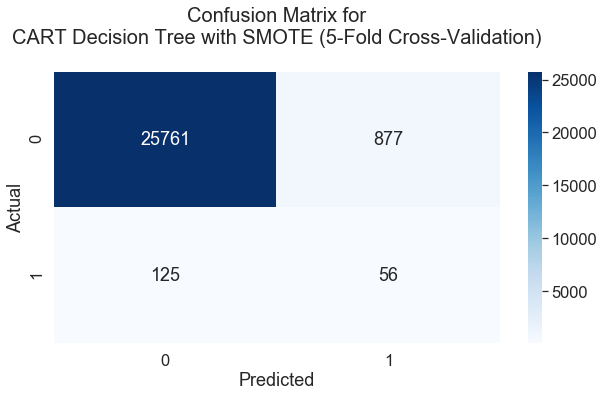

In [38]:
cm_data = confusion_matrix(all_y_true, all_y_preds)
df_cm = pd.DataFrame(cm_data, columns=np.unique(all_y_true), index=np.unique(all_y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':18}, fmt='g')
plt.title("Confusion Matrix for\nCART Decision Tree with SMOTE (5-Fold Cross-Validation)\n", size=20)
plt.show()

### 3.2 SMOTE (Oversampling) + Edited Nearest Neighbours (Undersampling)

In each split, <br>(1) Oversample to target a 1:2 minority:majority ratio (`sampling_strategy` = 0.5)<br>(2) Undersample with removal of majority class if all 5 nearest neighbours are minority classes

In [39]:
all_y_preds = []
all_y_proba = []
all_y_true = []
split = 1
for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    sm = SMOTE(random_state=SEED, sampling_strategy=0.5)
    ennObj = EditedNearestNeighbours(n_neighbors=5)
    smote_enn = SMOTEENN(smote=sm, enn= ennObj, random_state=SEED)
    X_smoteENN, y_smoteENN = smote_enn.fit_resample(X_train, y_train)
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    bankrupt_count_smoteENN = pd.DataFrame(y_smoteENN.value_counts()).rename(columns={'bankrupt':'Count'})
    bankrupt_count_smoteENN['Percentage of Total (%)'] = (bankrupt_count_smoteENN['Count']/len(y_smoteENN))*100
    print(f"\nSplit {split}:")
    print(bankrupt_count_smoteENN)
    
    dt_clf = DecisionTreeClassifier(random_state=SEED)
    dt_clf.fit(X_smoteENN, y_smoteENN)
    y_preds = dt_clf.predict(X_test)
    y_proba = dt_clf.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)
    split += 1


Split 1:
   Count  Percentage of Total (%)
0  19625                64.811757
1  10655                35.188243

Split 2:
   Count  Percentage of Total (%)
0  19381                64.525902
1  10655                35.474098

Split 3:
   Count  Percentage of Total (%)
0  19631                64.818728
1  10655                35.181272

Split 4:
   Count  Percentage of Total (%)
0  19426                 64.57897
1  10655                 35.42103

Split 5:
   Count  Percentage of Total (%)
0  19462                 64.62131
1  10655                 35.37869


#### Classification Report

In [40]:
print(classification_report(all_y_true, all_y_preds))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     26638
           1       0.06      0.48      0.11       181

    accuracy                           0.95     26819
   macro avg       0.53      0.72      0.54     26819
weighted avg       0.99      0.95      0.97     26819



#### F1-Score

In [41]:
f1_dt_smoteENN = f1_score(all_y_true, all_y_preds)
print(f"F1-Score: {f1_dt_smoteENN}") 

F1-Score: 0.10998735777496839


#### Confusion Matrix

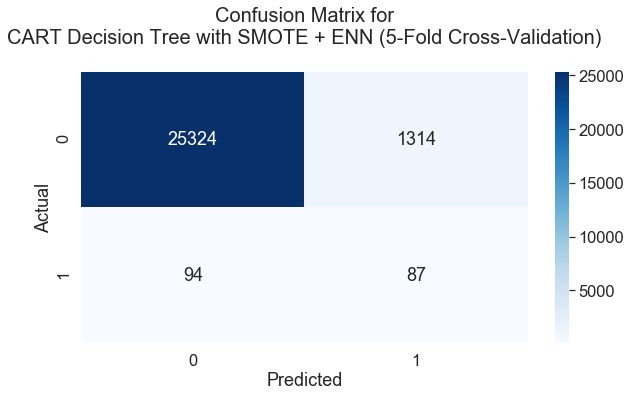

In [42]:
cm_data = confusion_matrix(all_y_true, all_y_preds)
df_cm = pd.DataFrame(cm_data, columns=np.unique(all_y_true), index=np.unique(all_y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':18}, fmt='g')
plt.title("Confusion Matrix for\nCART Decision Tree with SMOTE + ENN (5-Fold Cross-Validation)\n", size=20)
plt.show()

### 3.3 Over-Weighting Minority Class

In each split, over-weight rows of minority class (label = 1) by 40 times using `class_weight` parameter

In [43]:
weight = {0:1, 1:40}

In [44]:
all_y_preds = []
all_y_proba = []
all_y_true = []
for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]
    
    X_test = curr_test[x_var]
    y_test = curr_test[y_var]
    
    dt_clf = DecisionTreeClassifier(class_weight=weight, random_state=SEED)
    dt_clf.fit(X_train, y_train)
    y_preds = dt_clf.predict(X_test)
    y_proba = dt_clf.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

#### Classification Report

In [45]:
print(classification_report(all_y_true, all_y_preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     26638
           1       0.15      0.16      0.15       181

    accuracy                           0.99     26819
   macro avg       0.57      0.58      0.57     26819
weighted avg       0.99      0.99      0.99     26819



#### F1-Score

In [46]:
f1_dt_overweight = f1_score(all_y_true, all_y_preds)
print(f"F1-Score: {f1_dt_overweight}") 

F1-Score: 0.15425531914893617


#### Confusion Matrix

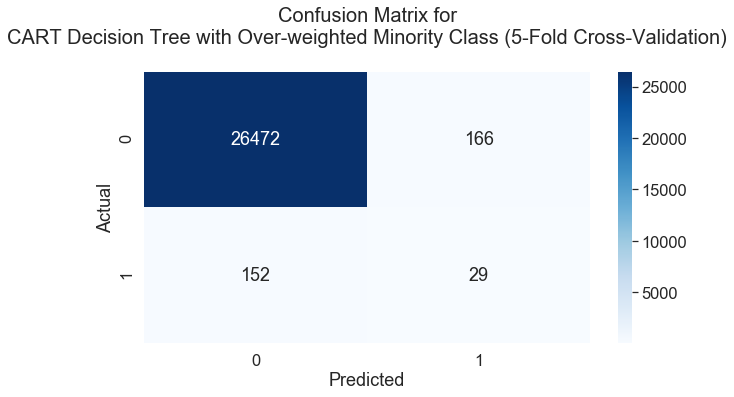

In [47]:
cm_data = confusion_matrix(all_y_true, all_y_preds)
df_cm = pd.DataFrame(cm_data, columns=np.unique(all_y_true), index=np.unique(all_y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={'size':18}, fmt='g')
plt.title("Confusion Matrix for\nCART Decision Tree with Over-weighted Minority Class (5-Fold Cross-Validation)\n", size=20)
plt.show()

<a id='imbalanced_evaluation'></a>

### 3.4 Evaluation

In [48]:
technique_performance = pd.DataFrame({"Technique": ["CART Decision Tree", 
                                                    "CART Decision Tree (SMOTE)", 
                                                    "CART Decision Tree (SMOTE + ENN)", 
                                                    "CART Decision Tree (Over-weight Minority)"],
                                      "F1-Score": [f1_dt, f1_dt_smote, f1_dt_smoteENN, f1_dt_overweight]})

technique_performance.sort_values(by="F1-Score", ascending=False)

,Technique,F1-Score
3,CART Decision Tree (Over-weight Minority),0.154255
0,CART Decision Tree,0.130890
2,CART Decision Tree (SMOTE + ENN),0.109987
1,CART Decision Tree (SMOTE),0.100539


Out of the 3 different methods to handle imbalanced class, only over-weighting the minority class helps in improving F1-Score. In fact, using SMOTE + ENN and SMOTE decrease the F1-Score.

## <a id='4'>Section 4</a>

In [49]:
pd.DataFrame(train.dtypes).rename(columns={0:'Data Type'})

,Data Type
gvkey,category
datadate,datetime64[ns]
conm,object
at,float64
cogs,float64
csho,float64
dvp,float64
ebit,float64
gp,float64
ib,float64


In [50]:
train.describe()

,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,ni,niadj,oiadp,pi,re,revt,sale,wcap,xido,xopr,mkvalt,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5
count,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000,26819.000000
mean,3915.880813,2296.434405,142.212575,1.088146,370.051918,1079.752864,182.198410,858.276254,2353.328278,177.498500,176.384387,370.051918,287.871638,676.185080,3376.187270,3376.187270,374.939495,-4.699910,2842.903636,4214.319994,0.006749,0.228964,-0.093309,0.063872,5.280239,1.033943
std,13419.380779,10071.695546,448.690088,11.656380,1648.483456,4097.193898,1216.434534,3287.416097,8189.983320,1369.879386,1369.599231,1648.483456,1823.769228,6423.763318,13421.011817,13421.011817,1635.854193,404.576121,11627.511520,16416.532733,0.081876,0.238151,1.366170,0.128516,23.276809,0.845404
min,100.002000,-0.206000,0.001000,-1013.000000,-8851.000000,-6887.000000,-44574.000000,0.000000,0.070000,-98696.000000,-98696.000000,-8851.000000,-44156.000000,-102362.000000,-0.002000,-0.002000,-19734.000000,-54122.000000,-43.906000,0.001300,0.000000,-4.756474,-55.591206,-2.218093,0.000008,-0.000020
25%,253.010000,109.694500,22.900500,0.000000,8.674000,74.797000,-2.570500,48.569500,94.391000,-3.443500,-3.904500,8.674000,-1.906500,-59.204500,212.708000,212.708000,34.941500,0.000000,183.701000,247.257800,0.000000,0.057624,-0.127166,0.026217,0.900691,0.491820
50%,665.297000,350.991000,44.283000,0.000000,47.547000,202.931000,21.507000,128.394000,323.232000,21.322000,21.004000,47.547000,31.243000,70.285000,597.779000,597.779000,109.757000,0.000000,494.496000,695.709200,0.000000,0.200202,0.128093,0.073382,2.062394,0.842522
75%,2266.698000,1240.225500,99.537000,0.000000,193.036000,643.293500,98.517000,443.099000,1272.518500,98.457000,98.081500,193.036000,142.839000,409.992000,1962.188000,1962.188000,301.532500,0.000000,1629.707000,2250.829250,0.000000,0.374881,0.348341,0.121601,5.004862,1.343228
max,331052.000000,346775.000000,10862.000000,340.000000,66290.000000,112370.000000,45220.000000,105501.634000,204822.718000,45220.000000,45220.000000,66290.000000,83397.000000,321816.000000,433526.000000,433526.000000,55597.000000,8313.000000,388666.000000,504239.580000,1.000000,0.999369,2.044237,1.271060,1945.385714,25.397335


### 4.1 Data Preprocessing

**Input Features:** 
- 5 financial ratios (numerical)
- All accounting variables (numerical)
- Industry classification code (categorical)

**Problems:**
- One problem with `sic` is that it has high cardinality (too many unique values). For categorical variables, the number of possible splits in a tree grows non-linearly with cardinality. Hence, this can be dealt with by mapping `sic` codes to their Industrial Division (maximum of 10 unique values - refer to sic-codes.csv file).
- Since XGBoost cannot handle categorical features, I need to transform `sic` feature (i.e. its mapped `division` feature) by encoding.
- Label encoding will be used for this assignment. With the [statistics on business bankruptcies by industry (2014 - 2018)](https://www.statista.com/statistics/1116955/share-business-bankruptcies-industry-united-states/), I will be encoding the `division` feature in order of share of bankruptcy cases filed between this period.

In [51]:
# Dropping columns that are not needed for training
train = train.drop(['gvkey', 'datadate', 'conm'], axis=1)

In [52]:
# Preparing dictionary for mapping `sic` to `division`
div_sic_map = pd.read_csv('sic-codes.csv')
div_sic_dict = pd.Series(div_sic_map.Division.values, index=div_sic_map.SIC).to_dict()

In [53]:
sic_in_csv = [key for key in div_sic_dict]
sic_in_df = list(train['sic'].unique())
sic_missing = [sic for sic in sic_in_df if sic not in sic_in_csv]
print(f'There are {len(sic_missing)} sic codes that are not mapped.')

There are 158 sic codes that are not mapped.


With missing sic codes in the csv, I will be manually mapping them to the following divisions based on their sic codes. Then, I will Label Encode based on their ranking by share of bankruptcy (2014-2018).

| Division | Code | Industry Title | Share of Bankruptcy (2014-2018) | Ranking by Share of Bankruptcy |
| --- | --- | --- | --- | --- |
| A | 01-09 | Agriculture, Forestry, Fishing | 4.23% | 4 |
| B | 10-14 | Mining | 0.85% | 1 |
| C | 15-17 | Construction | 9.68% | 7 |
| D | 20-39 | Manufacturing | 3.63% | 3 |
| E | 40-49 | Transportation, Communications, Electric, Gas, Sanitary Services | 5.38% | 5 |
| F | 50-51 | Wholesale Trade | 3.12% | 2 |
| G | 52-59 | Retail Trade | 12.76% | 8 |
| H | 60-67 | Finance, Insurance, Real Estate | 7.28% | 6 |
| I | 70-89 | Services | 50.27% | 9 |
| J | 90-99 | Public Administration | 0.04% | 0 |

In [54]:
def map_sic(x):
    code = str(x)[:-2]
    if len(code) == 1:
        # 01-09
        return 'A'
    else:
        if code[0] == '1':
            if int(code[1]) < 5:
                # 10-14
                return 'B'
            else:
                # 15-17
                return 'C'
        elif code[0] == '2' or code[0] == '3':
            # 20-39
            return 'D'
        elif code[0] == '4':
            # 40-49
            return 'E'
        elif code[0] == '5':
            if int(code[1]) < 2:
                # 50-51
                return 'F'
            else:
                # 52-59
                return 'G'
        elif code[0] == '6':
            # 60-67
            return 'H'
        elif code[0] == '7' or code[0] == '8':
            # 70-89
            return 'I'
        else:
            # 90-99
            return 'J'

In [55]:
train['division'] = train['sic'].apply(lambda x: map_sic(x))
train = train.drop(['sic'], axis=1)

In [56]:
train.head()

,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,ni,niadj,oiadp,pi,re,revt,sale,wcap,xido,xopr,mkvalt,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,division
0,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,3582.000,10052.000,501.000,501.000,1787.000,873.000,5414.000,37931.000,37931.000,1027.000,0.000,35118.000,11701.2500,0,0.064320,0.339074,0.111918,1.164072,2.375587,G
1,290.865,246.466,8.608,0.0,12.856,103.597,1.629,133.169,149.361,-22.709,-22.709,12.856,1.790,142.188,350.063,350.063,46.960,-24.338,326.107,101.5744,0,0.161449,0.488845,0.044199,0.680060,1.203524,I
2,307.329,325.912,8.163,0.0,22.236,138.591,22.554,66.035,159.356,22.309,22.309,22.236,30.007,134.708,464.503,464.503,92.256,-0.245,438.069,240.4004,0,0.300186,0.438319,0.072352,1.508575,1.511419,D
3,902.444,124.903,55.644,0.0,131.804,822.588,90.313,370.651,373.130,90.313,90.313,131.804,125.482,71.892,947.491,947.491,193.219,0.000,768.484,2281.4040,0,0.214106,0.079664,0.146052,6.114234,1.049917,I
4,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,301.453,444.242,-3.962,-3.962,54.842,-5.675,145.053,1755.848,1755.848,225.457,-4.911,1674.299,278.6950,0,0.321669,0.206953,0.078245,0.627350,2.505141,D


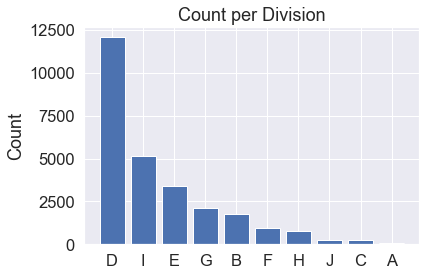

In [57]:
# Visualising new categorical feature `division`
data = train.division.value_counts().to_dict()
div = list(data.keys())
count = list(data.values())
y_pos = np.arange(len(div))

plt.bar(y_pos, count, align='center')
plt.xticks(y_pos, div)
plt.ylabel('Count')
plt.title('Count per Division')

plt.show()

In [58]:
# Encoding `division` with rank by share of bankruptcy statistics 
# (the larger the value, the more likely company goes bankrupt)

div_rank_map = {'A': 4,
                'B': 1,
                'C': 7,
                'D': 3,
                'E': 5,
                'F': 2,
                'G': 8,
                'H': 6,
                'I': 9,
                'J': 0}

In [59]:
def map_encode(x):
    return div_rank_map[x]

In [60]:
train['division_enc'] = train['division'].apply(lambda x: map_encode(x))
train = train.drop(['division'], axis=1)

In [61]:
train.head()

,at,cogs,csho,dvp,ebit,gp,ib,lct,lt,ni,niadj,oiadp,pi,re,revt,sale,wcap,xido,xopr,mkvalt,bankrupt,Altman_X1,Altman_X2,Altman_X3,Altman_X4,Altman_X5,division_enc
0,15967.000,26094.000,407.000,0.0,1787.000,11837.000,501.000,3582.000,10052.000,501.000,501.000,1787.000,873.000,5414.000,37931.000,37931.000,1027.000,0.000,35118.000,11701.2500,0,0.064320,0.339074,0.111918,1.164072,2.375587,8
1,290.865,246.466,8.608,0.0,12.856,103.597,1.629,133.169,149.361,-22.709,-22.709,12.856,1.790,142.188,350.063,350.063,46.960,-24.338,326.107,101.5744,0,0.161449,0.488845,0.044199,0.680060,1.203524,9
2,307.329,325.912,8.163,0.0,22.236,138.591,22.554,66.035,159.356,22.309,22.309,22.236,30.007,134.708,464.503,464.503,92.256,-0.245,438.069,240.4004,0,0.300186,0.438319,0.072352,1.508575,1.511419,3
3,902.444,124.903,55.644,0.0,131.804,822.588,90.313,370.651,373.130,90.313,90.313,131.804,125.482,71.892,947.491,947.491,193.219,0.000,768.484,2281.4040,0,0.214106,0.079664,0.146052,6.114234,1.049917,9
4,700.898,1044.110,17.484,0.0,54.842,711.738,0.949,301.453,444.242,-3.962,-3.962,54.842,-5.675,145.053,1755.848,1755.848,225.457,-4.911,1674.299,278.6950,0,0.321669,0.206953,0.078245,0.627350,2.505141,3


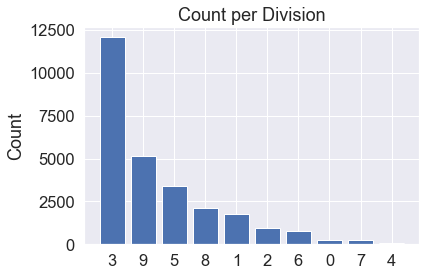

In [62]:
# Visualising new categorical feature `division_enc`
data = train.division_enc.value_counts().to_dict()
div = list(data.keys())
count = list(data.values())
y_pos = np.arange(len(div))

plt.bar(y_pos, count, align='center')
plt.xticks(y_pos, div)
plt.ylabel('Count')
plt.title('Count per Division')

plt.show()

In [63]:
x_var = list(train.columns.drop(['bankrupt']))
y_var = 'bankrupt'

### 4.2 Narrowing Hyperparameter Search Space with RandomizedSearch

Randomised Search defines a search space as a bounded domain of hyperparameter values and randomly sample points in that domain. It is a good method to find the best baseline hyperparameter. It is computationally less expensive compared to other baseline methods like Grid Search. Tests have also shown that Randomised Search is able to produce the best results most of the time.

I will be using this method to narrow down the search space before proceeding to tune the values of each hyperparameter with Hyperopt.

In [130]:
clf_xgb = XGBClassifier(objective = 'binary:logistic', n_jobs=4)
param_dist = {'n_estimators': stats.randint(100, 1000),
              'learning_rate': stats.uniform(0.01, 0.6),
              'subsample': stats.uniform(0.1, 1.0),
              'max_depth': [i for i in range(1, 33)],
              'colsample_bytree': stats.uniform(0.1, 1.0),
              'colsample_bylevel': stats.uniform(0.1, 1.0),
              'colsample_bynode': stats.uniform(0.1, 1.0),
              'min_child_weight': [1, 2, 3, 4, 5],
              'gamma': stats.randint(0, 20),
              'reg_lambda': stats.randint(1, 10),
              'reg_alpha': stats.uniform(0.01, 0.1),
              'scale_pos_weight': stats.randint(1, 100),
              'booster': ['gbtree', 'dart', 'gblinear']
             }

kf = StratifiedKFold(shuffle=False, n_splits=5)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions=param_dist,
                         cv=kf,  
                         n_iter=100,
                         scoring='roc_auc', 
                         error_score=0, 
                         verbose=3, 
                         n_jobs=4,
                         random_state=SEED,
                         return_train_score=True)

In [131]:
search = clf.fit(train[x_var], train[y_var])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 23.6min
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed: 73.3min
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed: 110.0min finished


In [134]:
top_5_params = pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').iloc[:5, :]

In [144]:
top_5_params = top_5_params.iloc[:,4:18].transpose()

In [145]:
top_5_params

,82,13,70,61,40
param_booster,gbtree,gbtree,gbtree,gbtree,gbtree
param_colsample_bylevel,0.478581,0.528382,0.844061,0.277161,0.846938
param_colsample_bynode,0.288194,0.461904,0.427867,0.672405,0.552405
param_colsample_bytree,0.847005,0.253338,0.344692,0.144845,0.550087
param_gamma,19,8,15,19,12
param_learning_rate,0.0488754,0.0367311,0.261147,0.123764,0.294402
param_max_depth,29,1,7,6,1
param_min_child_weight,2,1,3,3,2
param_n_estimators,787,696,840,354,652
param_reg_alpha,0.0625669,0.0716329,0.0486599,0.036126,0.08795


In [165]:
# 5-fold cross-validation for each set of hyperparameters
params_auc = {'params': [], 'auc': []}
for i in top_5_params.columns:
    curr_params = top_5_params[i][-1]
    all_y_preds = []
    all_y_proba = []
    all_y_true = []

    for train_index, test_index in kf.split(train[x_var], train[y_var]):
        curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
        X_train = curr_train[x_var]
        y_train = curr_train[y_var]

        X_test = curr_test[x_var]
        y_test = curr_test[y_var]

        xg_clf = XGBClassifier(objective = 'binary:logistic', n_jobs=4, **curr_params, random_state=SEED)
        xg_clf.fit(X_train, y_train)
        y_preds = xg_clf.predict(X_test)
        y_proba = xg_clf.predict_proba(X_test)
        all_y_preds.extend(y_preds)
        all_y_proba.extend(y_proba[:, 1])
        all_y_true.extend(y_test)

    auc_score = roc_auc_score(all_y_true, all_y_preds)
    params_auc['params'].append(curr_params)
    params_auc['auc'].append(auc_score)

In [166]:
# view cross-validation AUC of each set hyperparameters
pd.DataFrame(params_auc)

,params,auc
0,"{'booster': 'gbtree', 'colsample_bylevel': 0.4785805932506022, 'colsample_bynode': 0.2881942600298212, 'colsample_bytree': 0.8470048290299451, 'gamma': 19, 'learning_rate': 0.048875444808458485, 'max_depth': 29, 'min_child_weight': 2, 'n_estimators': 787, 'reg_alpha': 0.06256694443509794, 'reg_lambda': 9, 'scale_pos_weight': 60, 'subsample': 0.7442320198790318}",0.732013
1,"{'booster': 'gbtree', 'colsample_bylevel': 0.5283824051652493, 'colsample_bynode': 0.4619044427567548, 'colsample_bytree': 0.2533384779195744, 'gamma': 8, 'learning_rate': 0.036731127126857034, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 696, 'reg_alpha': 0.07163289451076758, 'reg_lambda': 1, 'scale_pos_weight': 84, 'subsample': 0.17197427968948678}",0.840963
2,"{'booster': 'gbtree', 'colsample_bylevel': 0.8440612531898167, 'colsample_bynode': 0.42786732533235206, 'colsample_bytree': 0.3446922276668436, 'gamma': 15, 'learning_rate': 0.2611468154584592, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 840, 'reg_alpha': 0.048659862805710746, 'reg_lambda': 4, 'scale_pos_weight': 65, 'subsample': 0.992900898791767}",0.678660
3,"{'booster': 'gbtree', 'colsample_bylevel': 0.2771611644384173, 'colsample_bynode': 0.6724051124346493, 'colsample_bytree': 0.14484533458908813, 'gamma': 19, 'learning_rate': 0.12376356869097792, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 354, 'reg_alpha': 0.036126036458527425, 'reg_lambda': 2, 'scale_pos_weight': 47, 'subsample': 0.6475914534866515}",0.688884
4,"{'booster': 'gbtree', 'colsample_bylevel': 0.8469384956075251, 'colsample_bynode': 0.5524048267464515, 'colsample_bytree': 0.5500867470007611, 'gamma': 12, 'learning_rate': 0.2944023559373164, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 652, 'reg_alpha': 0.0879500193183766, 'reg_lambda': 7, 'scale_pos_weight': 34, 'subsample': 0.7536897553047116}",0.751563


I will evaluate the top 5 sets of hyperparameters from Randomised Search. Each of these set of hyperparameters are cross-validated (5-folds) and I will pick the set with the best AUC to tune with Hyperopt.

### 4.3 Use Hyperopt to Find Best Hyperparameters

In [69]:
if not os.path.exists('Tuning'): os.mkdir('Tuning')

In [70]:
def save_file(path, data):
    output = open(path, 'wb')
    pickle.dump(data, output)
    output.close()

def load_file(path):
    pkl_file = open(path, 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [167]:
params_score = {'parameters': [], 'auc': []}

def hyperopt(param_space, X_train, y_train, X_test, y_test, num_eval, classifier):  
    start = time()
    
    def objective_function(params):
        clf = classifier(**params, random_state=SEED, objective = 'binary:logistic', n_jobs=4)
        score = cross_val_score(clf, X_train, y_train, cv=kf, scoring = 'roc_auc').mean()
        
        # saving parameter and its respective auc to params_score dict
        params_score['parameters'].append(params)
        params_score['auc'].append(score)
        
        return {'loss': -score, 'status': STATUS_OK, 'params': params}
    
    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials, 
                      rstate=np.random.RandomState(SEED))
    
    # find the trial with lowest loss value
    idx = np.argmin(trials.losses())
    print(idx)
    print(trials.trials[idx])

    params = trials.trials[idx]["result"]["params"]
    print(params)
    
    loss = [x['result']['loss'] for x in trials.trials] 
    best_param_values = best_param
    return trials, best_param_values

In [168]:
X = train[x_var]
y = train[y_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify = y)

From the best hyperparameters that I have picked from the previous step, I will expand the range of each of these hyperparameters. 

For `booster`, I will be including `dart` in the search space even though the top 5 hyperparameters used `gbtree` as the `booster`. This is due to the fact that `dart` may perform better than `gbtree` as it will drop trees in order to deal with overfitting.

In [169]:
num_eval = 50

XGB_param_hyperopt = {
    'booster': hp.choice('booster', ['gbtree', 'dart']), 
    'max_depth': scope.int(hp.quniform('max_depth', 1, 3, 1)),
    'subsample': hp.uniform('subsample', 0.1, 0.3),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.3),
    'colsample_bynode': hp.uniform('colsample_bynode', 0.3, 0.5),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.4, 0.6),
    'gamma': hp.uniform('gamma', 5, 9),
    'min_child_weight': hp.uniform('min_child_weight', 1, 3),
    'n_estimators': scope.int(hp.quniform('n_estimator', 600, 800, 1)),
    'reg_lambda': hp.uniform('reg_lambda', 1, 3),
    'reg_alpha':hp.uniform('reg_alpha', 0.06, 0.08),
    'learning_rate': hp.uniform('learning_rate', 0.02, 0.04),
    'scale_pos_weight': scope.int(hp.quniform('scale_pos_weight', 70, 90, 1))
}
try:
    XGB_hyperopt = load_file('Tuning/XGB_hyperopt_final.pkl')
except:
    XGB_hyperopt = hyperopt(XGB_param_hyperopt, X_train, y_train, X_test, y_test, num_eval, xgb.XGBClassifier)
    save_file('Tuning/XGB_hyperopt_final.pkl', XGB_hyperopt)

100%|█████████████████████████████████████████████| 50/50 [1:17:53<00:00, 93.46s/trial, best loss: -0.9352594702179647]
42
{'state': 2, 'tid': 42, 'spec': None, 'result': {'loss': -0.9352594702179647, 'status': 'ok', 'params': {'booster': 'dart', 'colsample_bylevel': 0.5790943648816523, 'colsample_bynode': 0.40970234708701153, 'colsample_bytree': 0.13309931865331168, 'gamma': 7.343183821638209, 'learning_rate': 0.021325065929116694, 'max_depth': 1, 'min_child_weight': 1.923674112345926, 'n_estimators': 713, 'reg_alpha': 0.07454108261110519, 'reg_lambda': 2.779048238718148, 'scale_pos_weight': 78, 'subsample': 0.285800697518754}}, 'misc': {'tid': 42, 'cmd': ('domain_attachment', 'FMinIter_Domain'), 'workdir': None, 'idxs': {'booster': [42], 'colsample_bylevel': [42], 'colsample_bynode': [42], 'colsample_bytree': [42], 'gamma': [42], 'learning_rate': [42], 'max_depth': [42], 'min_child_weight': [42], 'n_estimator': [42], 'reg_alpha': [42], 'reg_lambda': [42], 'scale_pos_weight': [42], 's

### 4.4 Evaluation

In [181]:
params_df = pd.DataFrame(params_score).sort_values(by='auc', ascending=False)
params_df_top_5 = params_df.iloc[:5,:]
params_df_top_5

,parameters,auc
42,"{'booster': 'dart', 'colsample_bylevel': 0.5790943648816523, 'colsample_bynode': 0.40970234708701153, 'colsample_bytree': 0.13309931865331168, 'gamma': 7.343183821638209, 'learning_rate': 0.021325065929116694, 'max_depth': 1, 'min_child_weight': 1.923674112345926, 'n_estimators': 713, 'reg_alpha': 0.07454108261110519, 'reg_lambda': 2.779048238718148, 'scale_pos_weight': 78, 'subsample': 0.285800697518754}",0.935259
28,"{'booster': 'dart', 'colsample_bylevel': 0.5036074005358407, 'colsample_bynode': 0.4883189961630391, 'colsample_bytree': 0.12030586603090371, 'gamma': 6.699318985694399, 'learning_rate': 0.02285961272871588, 'max_depth': 1, 'min_child_weight': 1.2690924079835466, 'n_estimators': 738, 'reg_alpha': 0.07902882848491988, 'reg_lambda': 2.3769668517870715, 'scale_pos_weight': 70, 'subsample': 0.29915990036412593}",0.935132
27,"{'booster': 'dart', 'colsample_bylevel': 0.5086418327379979, 'colsample_bynode': 0.44698790190160026, 'colsample_bytree': 0.15067975806884235, 'gamma': 7.560738101760692, 'learning_rate': 0.036388983784716555, 'max_depth': 1, 'min_child_weight': 1.5116711201016753, 'n_estimators': 733, 'reg_alpha': 0.07996015159475806, 'reg_lambda': 2.6547612116669623, 'scale_pos_weight': 90, 'subsample': 0.29501466444855534}",0.934717
48,"{'booster': 'dart', 'colsample_bylevel': 0.4141719586617114, 'colsample_bynode': 0.40703915012570546, 'colsample_bytree': 0.10791810627449161, 'gamma': 5.092624708551889, 'learning_rate': 0.02642163721988208, 'max_depth': 1, 'min_child_weight': 2.4470057076113814, 'n_estimators': 686, 'reg_alpha': 0.0720878094559176, 'reg_lambda': 1.6709634705183198, 'scale_pos_weight': 73, 'subsample': 0.2707782640287265}",0.934667
3,"{'booster': 'dart', 'colsample_bylevel': 0.5191881374236127, 'colsample_bynode': 0.4960598737596077, 'colsample_bytree': 0.18175008955539612, 'gamma': 8.92372845290391, 'learning_rate': 0.027057506246033546, 'max_depth': 2, 'min_child_weight': 2.379535292239969, 'n_estimators': 690, 'reg_alpha': 0.06560241124359512, 'reg_lambda': 2.5397357784605905, 'scale_pos_weight': 70, 'subsample': 0.2660798024414575}",0.934478


Looking at the top 5 best AUC, I will cross-validate with the train data to find the best AUC score.

In [192]:
params_auc_hp = {'params': [], 'auc': []}

for i in params_df_top_5.index:
    curr_params_hp = params_df_top_5['parameters'][i]
    all_y_preds = []
    all_y_proba = []
    all_y_true = []

    for train_index, test_index in kf.split(train[x_var], train[y_var]):
        curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
        X_train = curr_train[x_var]
        y_train = curr_train[y_var]

        X_test = curr_test[x_var]
        y_test = curr_test[y_var]

        xg_clf = XGBClassifier(objective = 'binary:logistic', n_jobs=4, **curr_params_hp, random_state=SEED)
        xg_clf.fit(X_train, y_train)
        y_preds = xg_clf.predict(X_test)
        y_proba = xg_clf.predict_proba(X_test)
        all_y_preds.extend(y_preds)
        all_y_proba.extend(y_proba[:, 1])
        all_y_true.extend(y_test)

    auc_score = roc_auc_score(all_y_true, all_y_preds)
    params_auc_hp['params'].append(curr_params_hp)
    params_auc_hp['auc'].append(auc_score)

In [194]:
pd.DataFrame(params_auc_hp)

,params,auc
0,"{'booster': 'dart', 'colsample_bylevel': 0.5790943648816523, 'colsample_bynode': 0.40970234708701153, 'colsample_bytree': 0.13309931865331168, 'gamma': 7.343183821638209, 'learning_rate': 0.021325065929116694, 'max_depth': 1, 'min_child_weight': 1.923674112345926, 'n_estimators': 713, 'reg_alpha': 0.07454108261110519, 'reg_lambda': 2.779048238718148, 'scale_pos_weight': 78, 'subsample': 0.285800697518754}",0.841097
1,"{'booster': 'dart', 'colsample_bylevel': 0.5036074005358407, 'colsample_bynode': 0.4883189961630391, 'colsample_bytree': 0.12030586603090371, 'gamma': 6.699318985694399, 'learning_rate': 0.02285961272871588, 'max_depth': 1, 'min_child_weight': 1.2690924079835466, 'n_estimators': 738, 'reg_alpha': 0.07902882848491988, 'reg_lambda': 2.3769668517870715, 'scale_pos_weight': 70, 'subsample': 0.29915990036412593}",0.839026
2,"{'booster': 'dart', 'colsample_bylevel': 0.5086418327379979, 'colsample_bynode': 0.44698790190160026, 'colsample_bytree': 0.15067975806884235, 'gamma': 7.560738101760692, 'learning_rate': 0.036388983784716555, 'max_depth': 1, 'min_child_weight': 1.5116711201016753, 'n_estimators': 733, 'reg_alpha': 0.07996015159475806, 'reg_lambda': 2.6547612116669623, 'scale_pos_weight': 90, 'subsample': 0.29501466444855534}",0.856527
3,"{'booster': 'dart', 'colsample_bylevel': 0.4141719586617114, 'colsample_bynode': 0.40703915012570546, 'colsample_bytree': 0.10791810627449161, 'gamma': 5.092624708551889, 'learning_rate': 0.02642163721988208, 'max_depth': 1, 'min_child_weight': 2.4470057076113814, 'n_estimators': 686, 'reg_alpha': 0.0720878094559176, 'reg_lambda': 1.6709634705183198, 'scale_pos_weight': 73, 'subsample': 0.2707782640287265}",0.839702
4,"{'booster': 'dart', 'colsample_bylevel': 0.5191881374236127, 'colsample_bynode': 0.4960598737596077, 'colsample_bytree': 0.18175008955539612, 'gamma': 8.92372845290391, 'learning_rate': 0.027057506246033546, 'max_depth': 2, 'min_child_weight': 2.379535292239969, 'n_estimators': 690, 'reg_alpha': 0.06560241124359512, 'reg_lambda': 2.5397357784605905, 'scale_pos_weight': 70, 'subsample': 0.2660798024414575}",0.822836


Best hyperparameters to use for prediction will be the hyperparameters in Index 2 as it has the highest AUC.

In [197]:
best_params = pd.DataFrame(params_auc_hp).iloc[2,0]

AUC: 0.8565267745699555


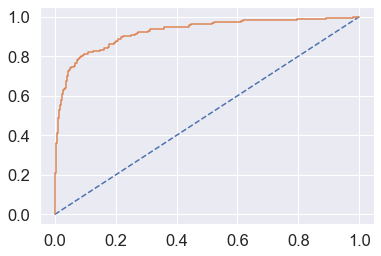

In [198]:
all_y_preds = []
all_y_proba = []
all_y_true = []

for train_index, test_index in kf.split(train[x_var], train[y_var]):
    curr_train, curr_test = train.iloc[train_index], train.iloc[test_index]
    X_train = curr_train[x_var]
    y_train = curr_train[y_var]

    X_test = curr_test[x_var]
    y_test = curr_test[y_var]

    xg_clf = XGBClassifier(objective = 'binary:logistic', n_jobs=4, **best_params, random_state=SEED)
    xg_clf.fit(X_train, y_train)
    y_preds = xg_clf.predict(X_test)
    y_proba = xg_clf.predict_proba(X_test)
    all_y_preds.extend(y_preds)
    all_y_proba.extend(y_proba[:, 1])
    all_y_true.extend(y_test)

auc_score = roc_auc_score(all_y_true, all_y_preds)
print(f'AUC: {auc_score}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.show()

### 4.5 Prediction on Test Dataset

#### Preprocess Test Dataset

In [172]:
test = pd.read_csv('test.csv')

In [173]:
test['division'] = test['sic'].apply(lambda x: map_sic(x))
test = test.drop(['sic', 'id', 'bankrupt'], axis=1)
test['division_enc'] = test['division'].apply(lambda x: map_encode(x))
test = test.drop(['division'], axis=1)

#### Prediction Probability for `bankruptcy`=1

In [201]:
final_params = {'booster': 'dart', 
                'colsample_bylevel': 0.5086418327379979, 
                'colsample_bynode': 0.44698790190160026, 
                'colsample_bytree': 0.15067975806884235, 
                'gamma': 7.560738101760692, 
                'learning_rate': 0.036388983784716555, 
                'max_depth': 1, 
                'min_child_weight': 1.5116711201016753, 
                'n_estimators': 733, 
                'reg_alpha': 0.07996015159475806, 
                'reg_lambda': 2.6547612116669623, 
                'scale_pos_weight': 90, 
                'subsample': 0.29501466444855534}

In [202]:
xg_clf = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=4, **final_params, random_state=SEED)
xg_clf.fit(train[x_var], train[y_var])
y_proba = xg_clf.predict_proba(test)
y_proba_pos = y_proba[:,1]

Output prediction probability for positive class to submission csv file.

In [203]:
id_col = [i for i in range(7711)]
predict_prob = y_proba_pos
output = pd.DataFrame(list(zip(id_col, predict_prob)), columns=['id', 'predict_prob'])
output.to_csv('submission_A0190140W.csv', index=False)

## <a id='5'>Section 5</a>

### 5.1 Best Model's Top 10 Features

The default importance type in XGBoost's feature importance plot is `weight`. However, `gain` would be a better importance type in determining which features are important in generating a prediction. `gain` implies the relative contribution of the corresponding feature to the model calculated by taking each feature's contribution for a tree in the model. Hence, the higher the value, the more important the feature is.

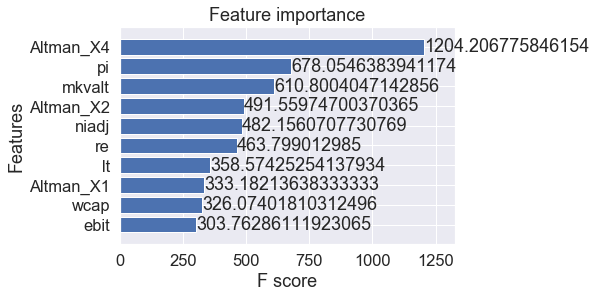

In [204]:
xgb.plot_importance(xg_clf, max_num_features=10, importance_type='gain', height=0.8)
plt.show()

### 5.2 Evaluation of Features

| Rank | Feature | Feature Importance (F-Score) |
| --- | --- | --- | 
| 1 | Altman_X4 | 1204.2 |
| 2 | pi | 678.1 |
| 3 | mkvalt | 610.8 |
| 4 | Altman_X2 | 491.6 |
| 5 | niadj | 482.2 |
| 6 | re | 463.8 |
| 7 | lt | 358.6 | 
| 8 | Altman_X1 | 333.2 | 
| 9 | wcap | 326.1 | 
| 10 | ebit | 303.8 |

`Altman_X2` is not the most important feature as Professor Altman had claimed. However, it is still within the top 10 features. Of the 5 Altman factors, only `Altman_X4`, `Altman_X2` and `Altman_X1` are important in contributing to the prediction with the XGBoost model.

`Altman_X1` is working capital/total assets. Working capital is the current assets minus current liabilities. It tells us if the company has more current assets to meet current liabilities in the short term. Working capital is directly related to the company's current financial health. By dividing working capital by total assets, the ratio tells us the company's efficiency in utilising assets to gain substanstial operational liquidity. Hence, it is an important feature in predicting bankruptcy.

`Altman_X2` is the retained earnings/total assets. A company may face bankruptcy if they are not able to generate enough sales or revenue to cover up losses currently. Any profitablity in the future may not be enough to cover the losses accumulated over the years. 

`Altman_X4` is the reversed gearing ratio (market value of equity/debt). Less debt means less leverage (hence less obligations for debt repayments and interest payments). Equity is a cheaper way of financing as there will be less outflow of the company if there are no dividends payouts. Hence, it is an important feature in predicting bankruptcy.

However, I feel that `Altman_X2` (though important) may not be the most accuracy in predicting bankruptcy. For a start-up that is still growing, they may incur a lot of initial capital expenditure, R&D expenses and other start-up costs, hence affecting their bottomline. While they may produce losses in the initial few years, thus hurting retained earnings, this is not accurate as the company may actually start to become profitable and show significant signs of growth. Due to poor retained earning, their `Altman_X2` factor is low and inaccurately predicting bankruptcy.